Raw data files can be accessed here: https://drive.google.com/drive/folders/1kPb_b0uydGXHF1bP08bP7PwmS9ItqGyd?usp=sharing

In [1]:
# Package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.pylab as pylab
import glob
import tabulate
import networkx as nx
import time
from tqdm import tqdm
from random import choice, sample
import random
from surprise import NormalPredictor, Reader, accuracy, SVD, SVDpp, KNNBasic, CoClustering, SlopeOne, Dataset, NMF, KNNBaseline, KNNWithMeans, KNNWithZScore, BaselineOnly
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split
from collections import defaultdict
import timeit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import itertools
from ast import literal_eval
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from  itertools import chain
from collections import Counter

# Note nxviz and networkx packages may introduce conflicts with other packages
#import nxviz 
#from networkx.algorithms import bipartite
#from nxviz import CircosPlot

# Plotting defaults
params = {'legend.fontsize': 15,
         'axes.labelsize': 15,
         'axes.titlesize':20,
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'legend.title_fontsize': 15,
         'figure.figsize': (10,10)
         }
pylab.rcParams.update(params)

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

# Raw File Imports

Import files describing recipes and recipe reviews by users.

In [2]:
def file_importer(file, sub_dir='../data/raw', compression='zip',**kwargs):
    """`
    Returns dataframe of csv files
    
    Parameters:
    sub_dir (string): data sub-folder name, i.e. '../data/raw'
    file (string): file name
    compression (string): compression type, i.e. 'zip'
    
    Optional Arguments:
    columns (list): list of column names to be included
    date_parser (list): list of column(s) to parse as date
    
    """
    path = sub_dir + '/' + file
    if ("columns" in kwargs and "date_parser" in kwargs):
        file_df = pd.read_csv(path, 
                          header=0, 
                          sep=',', 
                          #nrows=10000,
                          compression=compression,
                          columns=kwargs['columns'],
                          parse_dates=kwargs['date_parser'],
                          infer_datetime_format=True)
    elif ("columns" in kwargs):
        file_df = pd.read_csv(path, 
                          header=0, 
                          sep=',', 
                          #nrows=10000,
                          compression=compression,
                          columns=kwargs['columns'])   
    elif ("date_parser" in kwargs):
        file_df = pd.read_csv(path, 
                          header=0, 
                          sep=',', 
                          #nrows=10000,
                          compression=compression,
                          parse_dates=kwargs['date_parser'],
                          infer_datetime_format=True)
    else:
        file_df = pd.read_csv(path, 
                          header=0, 
                          sep=',', 
                          #nrows=10000,
                          compression=compression)
        
 
    return file_df

# Import raw files for interactions and recipes
interactions_df = file_importer(file='RAW_interactions.csv.zip', sub_dir= '../../exploration/data/raw',date_parser=['date'])
recipes_df = file_importer(file='RAW_recipes.csv.zip', sub_dir= '../../exploration/data/raw', date_parser=['submitted'])

In [3]:
display(interactions_df.head(5))
display(interactions_df.info(verbose=True))

print("Raw Interactions File")
interaction_file_descr = [['field', 'description', 'notes'],
                          ['user_id', 'food.com user who has submitted rating for corresponding recipe',],
                          ['recipe_id', 'food.com recipe identifier to match to corresponding recipe in recipe file',],
                          ['date', 'date of review','converted to datetime field'],
                          ['rating', '1-5 rating',],
                          ['review', 'user entered free text','possible opportunity for sentiment analysis in future; does contain some null values'],
                         ]
print(tabulate.tabulate(interaction_file_descr))

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
user_id      1132367 non-null int64
recipe_id    1132367 non-null int64
date         1132367 non-null datetime64[ns]
rating       1132367 non-null int64
review       1132198 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 43.2+ MB


None

Raw Interactions File
---------  --------------------------------------------------------------------------  ------------------------------------------------------------------------------------
field      description                                                                 notes
user_id    food.com user who has submitted rating for corresponding recipe
recipe_id  food.com recipe identifier to match to corresponding recipe in recipe file
date       date of review                                                              converted to datetime field
rating     1-5 rating
review     user entered free text                                                      possible opportunity for sentiment analysis in future; does contain some null values
---------  --------------------------------------------------------------------------  ------------------------------------------------------------------------------------


In [4]:
print(interactions_df["rating"].describe().apply(lambda x: format(x, 'f')))
for pctl in np.linspace(.1,.5,5):
    print(round(pctl,1) , ':', interactions_df['rating'].quantile(pctl))

count    1132367.000000
mean           4.411016
std            1.264752
min            0.000000
25%            4.000000
50%            5.000000
75%            5.000000
max            5.000000
Name: rating, dtype: object
0.1 : 3.0
0.2 : 4.0
0.3 : 5.0
0.4 : 5.0
0.5 : 5.0


80% of the ratings have a 4+ rating, which will likely have a strong effect on rating predictions.

In [5]:
display(recipes_df.head(5))
display(recipes_df.info(verbose=True))

print("Raw Recipes File")
recipe_file_descr = [['field', 'description', 'notes'],
                          ['name', 'recipe description','1 recipe does not have a name'],
                          ['recipe_id', 'food.com recipe identifier to match to correspnding recipe in recipe file',],
                          ['minutes', 'number of minutes to prepare recipe',],
                          ['contributor_id', 'food.com user identifier to match to correspnding user in interactions file',],
                          ['submitted', 'recipe submission date','converted to datetime field',],
                          ['tags', 'recipe keywords', 'should be vectorized for content filtering'],
                          ['nutrition', 'nutrition information (calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat (PDV) , and carbohydrates (PDV))',],
                          ['n_steps', 'number of steps in recipe',],
                          ['steps', 'text for recipe steps, in order',],
                          ['description', 'user-provided description','some descriptions are missing'],
                          ['ingredients', 'list of ingredient names',],
                          ['n_ingredients', 'number of ingredients in recipe',],
                      ]
print(tabulate.tabulate(recipe_file_descr))

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
name              231636 non-null object
id                231637 non-null int64
minutes           231637 non-null int64
contributor_id    231637 non-null int64
submitted         231637 non-null datetime64[ns]
tags              231637 non-null object
nutrition         231637 non-null object
n_steps           231637 non-null int64
steps             231637 non-null object
description       226658 non-null object
ingredients       231637 non-null object
n_ingredients     231637 non-null int64
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 21.2+ MB


None

Raw Recipes File
--------------  -------------------------------------------------------------------------------------------------------------------------------------------------  ------------------------------------------
field           description                                                                                                                                        notes
name            recipe description                                                                                                                                 1 recipe does not have a name
recipe_id       food.com recipe identifier to match to correspnding recipe in recipe file
minutes         number of minutes to prepare recipe
contributor_id  food.com user identifier to match to correspnding user in interactions file
submitted       recipe submission date                                                                                                                             converted to datet

# Initial Data Cleaning

Self-Loops may be created in Networks/Graphs if there are matching identifiers across user_id and recipe_id. These self-loops inhibit bipartite 
graph creation so they will be removed by creating new identifiers unique to user and recipe series, respectively.

In [6]:
interactions_df['new_user_id'] = interactions_df['user_id'].apply(lambda x: 'u'+str(x))
interactions_df['new_recipe_id'] = interactions_df['recipe_id'].apply(lambda x: 'r'+str(x))

Remove review of recipe that does not have a corresponding recipe name from recipe file

In [7]:
missing_rec_name_id = recipes_df['id'].loc[recipes_df.name.isnull()].unique()
interactions_df = interactions_df[~interactions_df['recipe_id'].isin(missing_rec_name_id)]

In [8]:
print("Unique recipes: {}".format(len(interactions_df['new_recipe_id'].unique())))
print("Unique users: {}".format(len(interactions_df['new_user_id'].unique())))

Unique recipes: 231636
Unique users: 226569


# Initial Data Exploration

Below the relationship between users and recipes will be evaluated along with the distribution of typical ratings. 

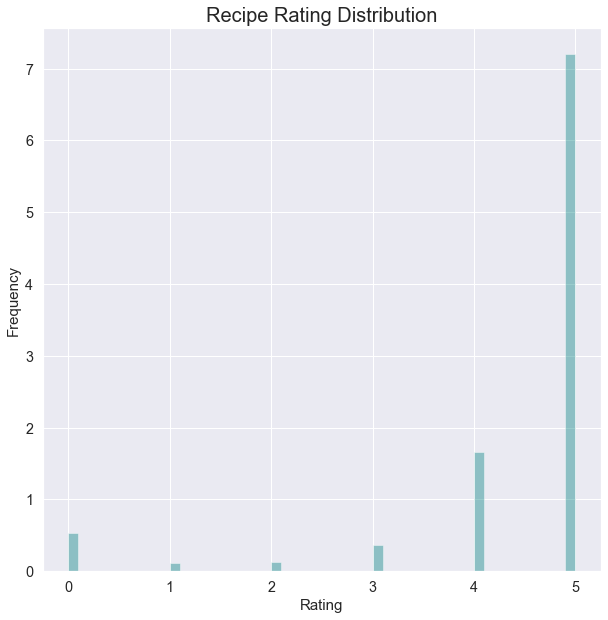

In [13]:
# Evaluate typical rating submissions
_ = sns.distplot(interactions_df['rating'], 
                kde=False,
                color='teal',
                norm_hist=True)
_ = plt.title('Recipe Rating Distribution')
_ = plt.xlabel('Rating')
_ = plt.ylabel('Frequency')
plt.show()

As noted prior, ratings are skewed to the right with the vast majority of ratings 4-5. Additionally, 0 has slightly more submissions that 1-3. These outwardly skewed ratings should in theory lead to polar extremes in rating predictions. Furthermore, a distribution like the above indicates that the mean may not be an appropriate aggregate assessment of user ratings, and a median should be used instead.

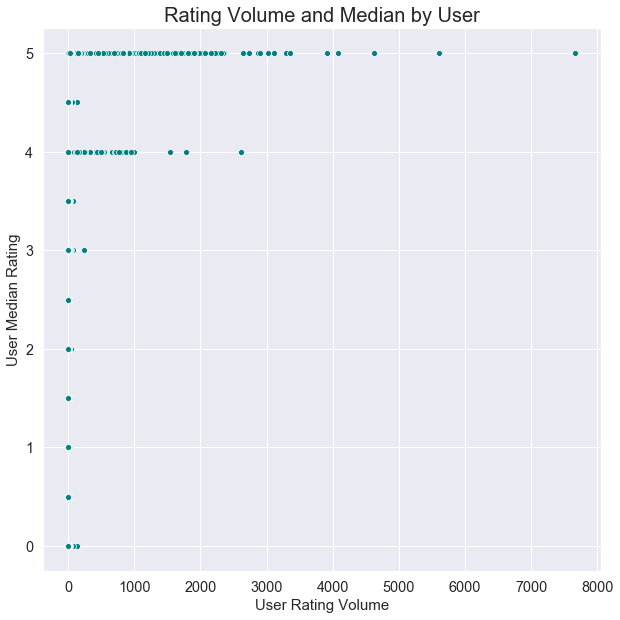

In [14]:
# Plot user rating volume and median rating by user
user_rating_grp = interactions_df.groupby(by='new_user_id',as_index=False).agg(rating_vol=('rating','count'),rating_med=('rating','median'))

_ = sns.scatterplot(x='rating_vol',
                    y='rating_med',
                    data=user_rating_grp,
                    legend=False,
                    color='teal')
plt.xlabel('User Rating Volume')
plt.ylabel('User Median Rating')
plt.title('Rating Volume and Median by User')
plt.show()

The above plot highlights that users tend to favor higher ratings as they submit more ratings.

In [15]:
def neighbor_pctls(df, column_to_group):
    """`
    Returns statisical distribution figures of rating submission by grouping
    
    Parameters:
    df (dataframe): interactions dataframe
    column_to_group (string): column name to group rating interactions by
    
    """
    new_df = df.groupby([column_to_group]).size().to_frame('size')
    print('Interactions by {}'.format(column_to_group))
    display(new_df.describe())


user_nghbors_std = neighbor_pctls(interactions_df,'user_id')
recipe_nghbors_std = neighbor_pctls(interactions_df,'recipe_id')

Interactions by user_id


,size
count,226569.000000
mean,4.997886
std,49.663220
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,7671.000000


Interactions by recipe_id


,size
count,231636.000000
mean,4.888558
std,17.532517
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,1613.000000


Evaluating the above rating submissions by both user and recipe highlights that the sparse nature of the data. Typical users submit between 1-2 with considerable outliers up to 7.7k ~rating submissions. Similarly, most recipes have been 1-2 ratings submitted with outliers up to 1.6k ratings.

To visualize these heavily skewed distributions, the number ratings by user and recipe are shown below. The distributions will be limited to those within 2 standard deviations
of the mean. Since the distributions are skewed heavily to the left, including 2 standard deviations above the mean is likely generous for inclusion.

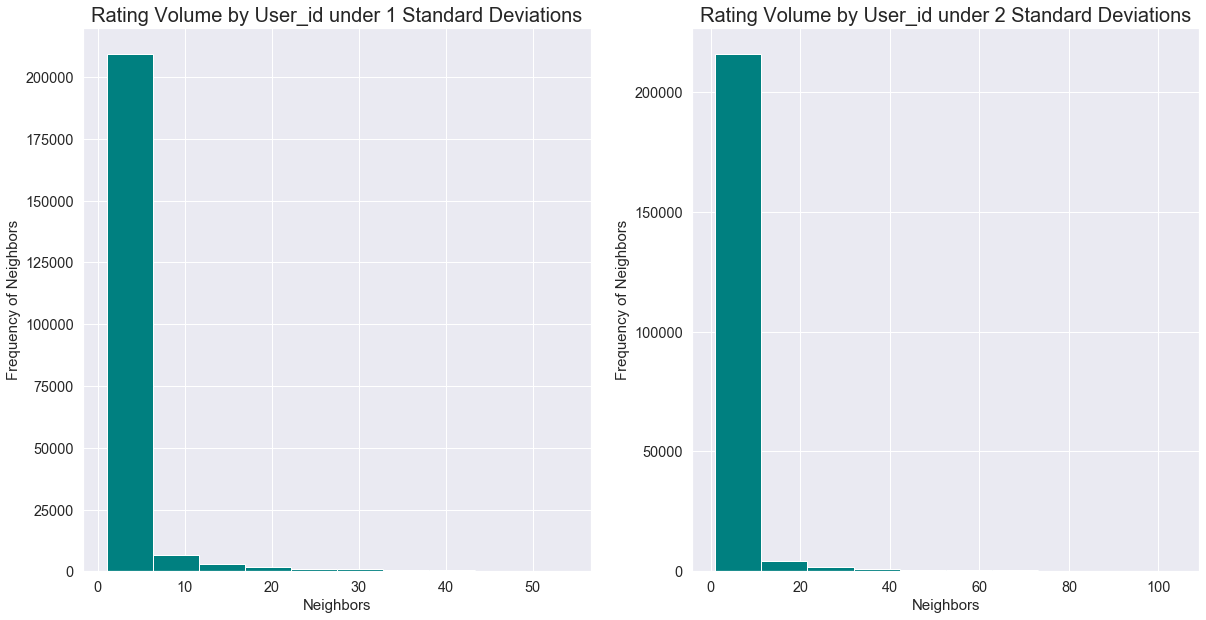

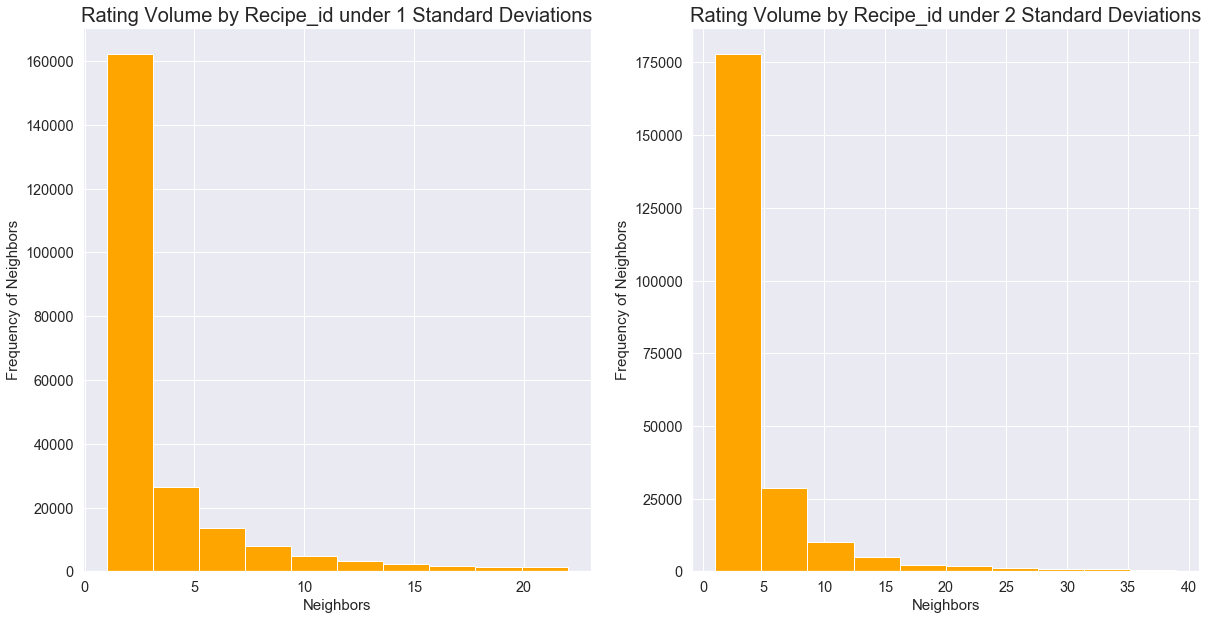

In [16]:
def neighbor_dist(df, column_to_group,color='teal'):
    """`
    Returns histogram of rating submissions/interactions grouped by user-entered column and within 1 and 2 standard deviations of mean submissions
    
    Parameters:
    df (dataframe): interactions dataframe
    column_to_group (string): column name to group rating interactions by
    color (string): optional color argument for histogram
    
    """
    plt.figure(figsize=(20,10))
    for std_n in np.arange(1,3):
        new_df = df.groupby([column_to_group]).size().to_frame('size')
        mean_n = np.mean(new_df['size'])
        std_dev = np.std(new_df['size']) 
        new_df = new_df.loc[new_df['size']<=(mean_n + (std_n*std_dev))]
        plt.subplot(1,2,std_n)
        _ = plt.hist(new_df['size'],
                     color=color)
        plt.title("Rating Volume by {} under {} Standard Deviations".format(column_to_group.capitalize(), std_n))
        plt.xlabel('Neighbors')
        plt.ylabel('Frequency of Neighbors')
    plt.show()


neighbor_dist(interactions_df,'user_id',)
neighbor_dist(interactions_df,'recipe_id', color='orange')

# EDA with a Network Graph

Addtional exploration and visualizing leveraging a network graph structure follows. Recipes and Users will make up the 2 node types of the bipartite graph with the reviews represented as edges. Due to the size of the dataset however, exploration will be limited using this structure.

In [8]:
# Function to create bipartite networkx graph
def create_bipartite(df=interactions_df, 
                     bipartite_1_col='new_user_id', 
                     bipartite_1_name='user', 
                     bipartite_2_col='new_recipe_id', 
                     bipartite_2_name='recipe'):
    
    """`
    Returns bipartite networkx graph from dataframe
    
    Defaulted Parameters:
    bipartite_1_col (string): dataframe column corresponding to origin ID ('new_user_id'), 
    bipartite_1_name (string): origin bipartite of graph ('user'), 
    bipartite_2_col (string): dataframe column corresponding to destination ID ('new_recipe_id'), , 
    bipartite_2_name (string): origin bipartite of graph ('recipe'), 
    
    """
    
    # Instantiate a new Graph: G
    G = nx.Graph()
    
    # Add nodes from each of the partitions
    G.add_nodes_from(df[bipartite_1_col], bipartite=bipartite_1_name)
    G.add_nodes_from(df[bipartite_2_col], bipartite=bipartite_2_name)

    # Add in each edge along with the date the edge was created
    for r, d in df.iterrows():
        G.add_edge(d[bipartite_1_col],d[bipartite_2_col],rating=d['rating']) 
    
    # Return graph
    return G

interactions_graph = create_bipartite()

# Confirm output types
print(type(interactions_graph))
print(bipartite.is_bipartite(interactions_graph))  

<class 'networkx.classes.graph.Graph'>
True


In [9]:
users = [u for u, d in interactions_graph.nodes(data=True) if d['bipartite'] == 'user']
print('Number of users: {}'.format(len(users)))

recipes = [r for r, d in interactions_graph.nodes(data=True) if d['bipartite'] == 'recipe']
print('Number of recipes: {}'.format(len(recipes)))

print('Number of edges: {}'.format(len(interactions_graph.edges())))

Number of users: 226569
Number of recipes: 231636
Number of edges: 1132366


Below, a smaller sample (due to resource constraints) is visualized using a CircosPlot. 

100%|██████████| 14745/14745 [00:00<00:00, 246747.39it/s]


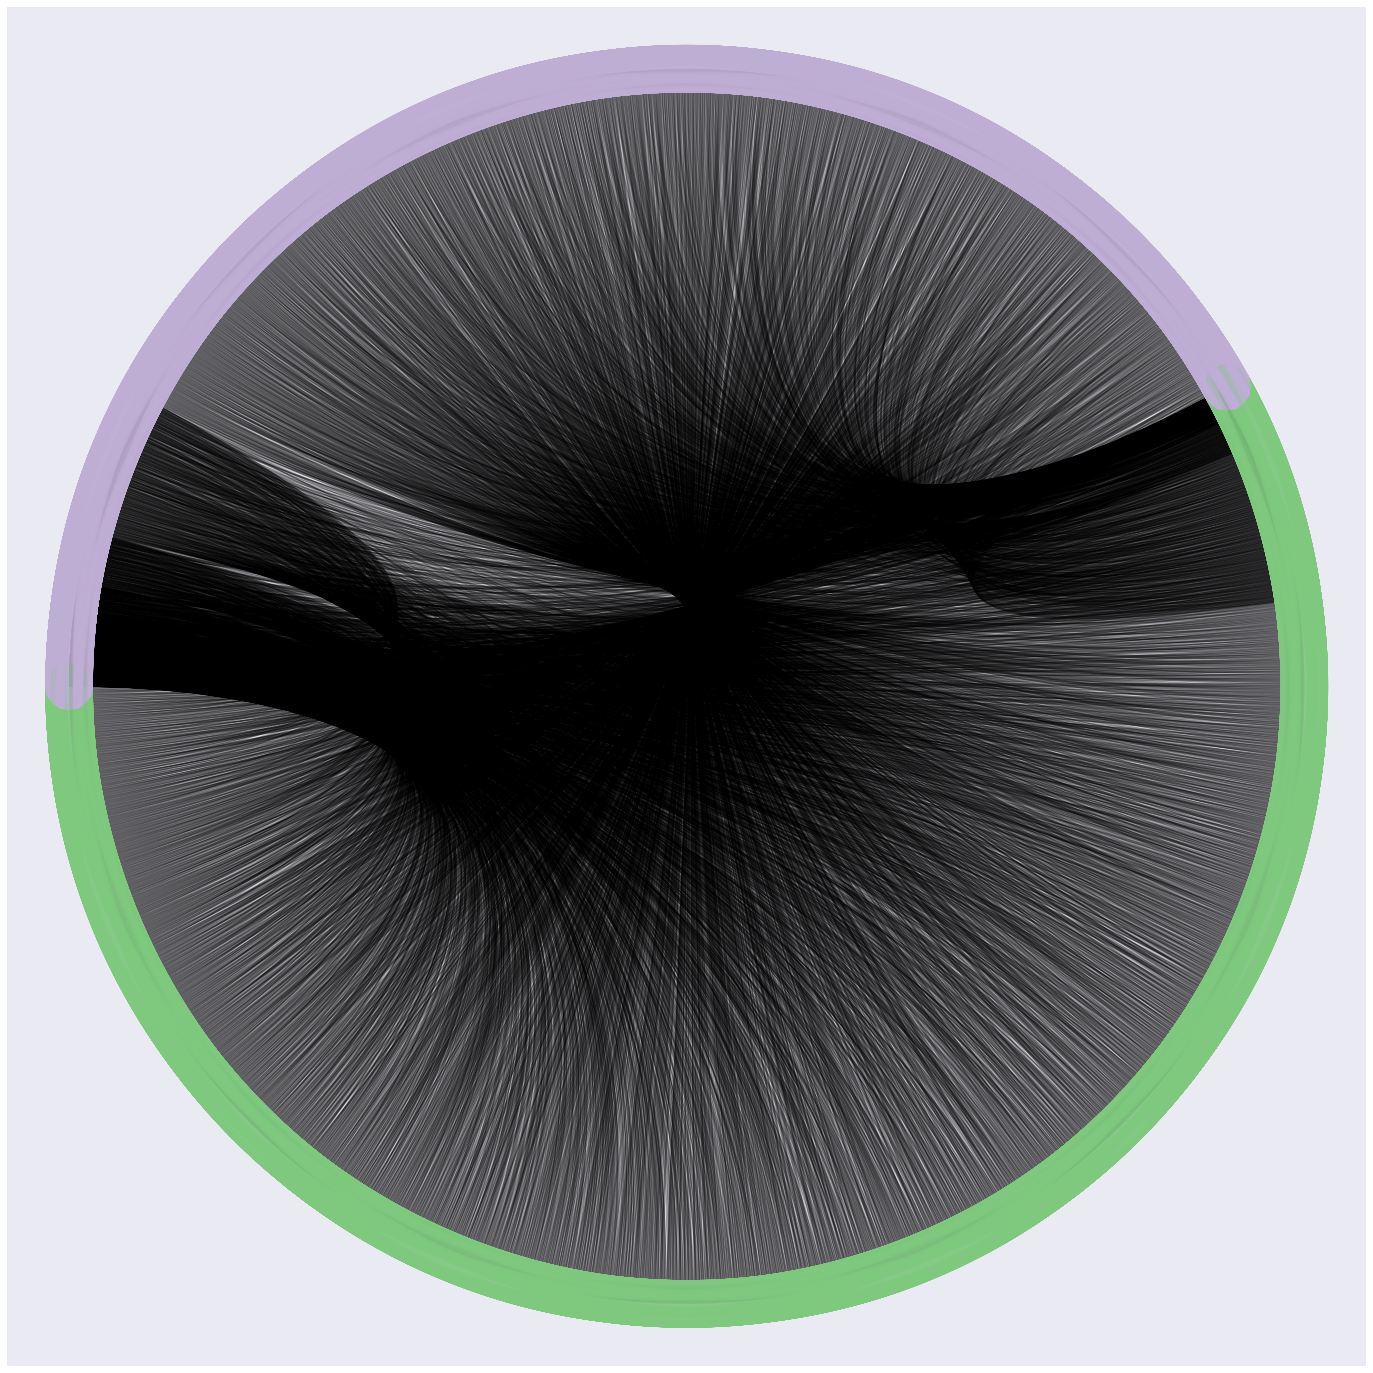

In [88]:
# Reduce the size of the graph for CircosPlot by sampling from the origin dataframe and re-creating graph
interactions_subgraph = create_bipartite(interactions_df.sample(n=10000, random_state=13))

# Add the degree centrality score of each node to their metadata dictionary
dcs = nx.degree_centrality(interactions_subgraph)
for n in tqdm(interactions_subgraph.nodes()):
    interactions_subgraph.node[n]['centrality'] = dcs[n]


# Create the circos plot to display degree centrality grouped by bipartite
deg_cent_circos = CircosPlot(interactions_subgraph, node_color='bipartite', node_grouping = 'bipartite', node_order='centrality',figsize=(25,25))
deg_cent_circos.draw()
plt.show()

# Initial Model Evaluation for Collaborative Filtering (using surprise package)

The provided dataset from kaggle does not include users without recipe ratings. Thus, for this dataset, there will be no cold start users. However, if this prototype were to be operationalized, there would need to be a distinction between new and existing users (otherwise noted as users with past rating submissions). For the former, a different approach, such as simply recommending popular recipes, would need to be taken. The below function can be used to distinguish new and existing users.

It is also worth noting that there are numerous users who's mean rating is 0. This is oftentimes the case for users who submit a single rating, which happens to be 0. The Surprise cross_validate object will not allow this. Thus, the below function will also update these 0 ratings to be 0.1.

In [9]:
def repeat_or_first_time_users(df):
    """`
    Returns 2 dataframes corresponding to new and existing users and augment mean ratings of 0 to 0.1
    
    Parameters:
    df (dataframe): interactions dataframe
        
    """
    # Set ratings of 0 to 0.1
    idx = df.loc[df.rating==0].index
    df.loc[idx,'rating'] = 0.1
    
    repeaters = df.groupby('new_user_id').filter(lambda x: len(x) > 1)
    first_timers = df.groupby('new_user_id').filter(lambda x: len(x) == 1)

    return repeaters, first_timers

repeater_data, first_timer_data = repeat_or_first_time_users(interactions_df)

Next, the interactions dataframe is converted into a dataframe with data types and columns more suited for the surprise structure.

In [10]:
def create_user_ratings_df(df):
    """`
    Returns dataframe with ratings as a mean float type
    
    Parameters:
    df (dataframe): interactions dataframe
        
    """
    df = df.groupby(['new_user_id','new_recipe_id'])['rating'].agg(['mean']).reset_index()
    
    df = df.rename({'mean':'estimator'}, axis=1)
    df['estimator'] = round(df['estimator'].astype('float64'),1)
    return df

user_ratings_df = create_user_ratings_df(repeater_data)
user_ratings_df.head()

,new_user_id,new_recipe_id,estimator
0,u10000120,r39087,0.1
1,u10000120,r95222,3.0
2,u1000036,r119158,5.0
3,u1000036,r28261,0.1
4,u1000048,r332505,5.0


Next, the dataframe is turned into a Surprise package matrix object with users as rows, recipes as columns, and ratings as their intersection points. 
The input dataframe from the prior function is sampled to 10k records for initial algorithm comparisons

In [11]:
def create_interactions_matrix(df):
    """`
    Returns ratings matrix with users as rows and recipes as columns
    
    Parameters:
    df (dataframe): interactions dataframe
        
    """
    # Create rating boundaries
    scale = (df.estimator.min(), df.estimator.max())
    # Parse dataframe
    reader = Reader(rating_scale=scale)
    
    new_df = Dataset.load_from_df(df[['new_user_id',
                                      'new_recipe_id',
                                      'estimator']], reader)  
    return new_df

# Sample from input dataframe to create smaller matrix for algorithm testing
interactions_matrix = create_interactions_matrix(user_ratings_df.sample(10000, random_state=13))

Basic algorithms from Surprise will be used to compare baseline performance of each algorithm's out of the box configurations. The matrix created from the sampled 10k ratings will be used for this particular exercise.

In [16]:
# Create list of baseline algorithms
algorithm = [SVD(), 
             SVDpp(), 
             SlopeOne(), 
             NMF(), 
             NormalPredictor(), 
             KNNBaseline(), 
             KNNBasic(), 
             KNNWithMeans(), 
             KNNWithZScore(), 
             BaselineOnly(), 
             CoClustering()]

In [17]:
# Iterate over cross-validation of each algorithm calculating mean RMSE
cv_output = pd.DataFrame(columns = ['algorithm','rmse_values', 'rmse_mean'])
cv_mean_rmse = []
for algo in algorithm:
    results = cross_validate(algo, interactions_matrix, measures=['rmse'], cv=3, verbose=0)
    cv_mean_rmse = {'algorithm':str(algo).split('.')[3].split(' ')[0],
                    'rmse_values':results['test_rmse'],
                    'rmse_mean': np.array(list(results['test_rmse'])).mean(),
                    'fit_time': np.array(list(results['fit_time'])).mean()}
    cv_output = cv_output.append(cv_mean_rmse, ignore_index=True)

display(cv_output.sort_values('rmse_mean', ascending=True))

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,algorithm,rmse_values,rmse_mean,fit_time
0,SVD,"[1.0735321423250106, 1.0487117910961885, 1.037...",1.053204,0.506977
1,SVDpp,"[1.0671881260889464, 1.0397728459322257, 1.055...",1.054023,1.105523
5,KNNBaseline,"[1.0831437858335389, 1.0387536359422382, 1.040...",1.054293,0.368233
9,BaselineOnly,"[1.0971830629936459, 1.0126677357191867, 1.056...",1.055570,0.039887
6,KNNBasic,"[1.046698467702671, 1.0704131402263959, 1.0659...",1.061019,0.362084
2,SlopeOne,"[1.0819668503963242, 1.064075455817377, 1.0612...",1.069088,0.799186
7,KNNWithMeans,"[1.0714918372691802, 1.0774148633671228, 1.074...",1.074481,0.419308
8,KNNWithZScore,"[1.0733282575774903, 1.0848119219180001, 1.070...",1.076161,0.526833
10,CoClustering,"[1.054755107019974, 1.1149743980556954, 1.0719...",1.080576,1.219688
3,NMF,"[1.1027666899951927, 1.1589253361386889, 1.114...",1.125473,1.196066


Running a gridsearch of the 11 basic Surprise algorithms on 10k records of the roughly 1 million records shows that SVD++ had the lowest mean rmse. The SVD++ (singular value decomposition ++) algorithm, an extension of SVD taking into account implicit ratings. Here, an implicit rating describes the fact that a user rated an item, regardless of the rating value. Furthermore, the top 4 performing algorithms are very close in their average RMSE. Additionally, the train time of SVD++ is over double that of the next best algorithm - SVD. Given the size of the dataset, SVD and BaselineOnly will be reviewed further.

SVD is a matrix factorization-based algorithm.
BaselineOnly algorithm predicts the baseline estimate for given user and item.

Below, the train times of SVD and Baseline Only will be compared on a subset of the data as a training object. This can be extrapolated to a larger set to gain an understanding of the full training time for each algorithm.

In [18]:
SVD_algo = SVD()
Baseline_algo = BaselineOnly()

# Recreate repeater and first_time datasets ensuring sort by rating submission date.
repeater_data_sorted, first_timer_data_sorted =repeat_or_first_time_users(interactions_df.sort_values('date',ascending=False))

# Recreate ratings dataframe
user_ratings_df_sorted = create_user_ratings_df(repeater_data_sorted)

# Recreate interactions matrix carrying sort and train and test splits for subset 1 of 2
interactions_matrix = create_interactions_matrix(user_ratings_df_sorted.iloc[0:100000])
trainset_100k, testset_100k = train_test_split(interactions_matrix, test_size=0.01, train_size=0.99, shuffle=False)

# Recreate interactions matrix carrying sort and train and test splits for subset 2 of 2
interactions_matrix = create_interactions_matrix(user_ratings_df_sorted.iloc[0:300000])
trainset_300k, testset_300k = train_test_split(interactions_matrix, test_size=0.01, train_size=0.99, shuffle=False)

print("SVD time on ~100k")
%timeit -t SVD_algo.fit(trainset_100k)

print("Baseline Only time on ~100k")
%timeit -t Baseline_algo.fit(trainset_100k)

print("SVD time on ~300k")
%timeit -t SVD_algo.fit(trainset_300k)

print("Baseline Only time on ~300k")
%timeit -t Baseline_algo.fit(trainset_300k)

SVD time on ~100k
6.96 s ± 786 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Baseline Only time on ~100k
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
328 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SVD time on ~300k
22.3 s ± 1.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Baseline Only time on ~300k
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
1.08 s ± 23.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Evaluating the 2 algorithm's training time on ~100k and ~300k samples shows that training time does not quite scale linearly with increased data size. For example, SVD train time on ~100k was 13.4 seconds and 1 min 36 seconds on ~300k rows. More importantly however, neither algorithm shows unreasonably high training times on ~300k rows. Thus, with a full dataset of just above a million, both algorithms can be pursued with minor concern for training runtime.

# Refining Collaborative Filtering with SVD and Baseline Only

In [97]:
def gridsearch(algo, param_grid, data, cv=5):
    """
    Performs gridsearch on training data to provide optimal hyperparameters of algorithm specified
    
    Parameters:
    algo: selected algorithm
    param_grid (dict): parameter grid of hyperparameter options
    data: interactions matrix (train_set)
    cv (integer): cross-validation iterations
        
    """
    gs_cv = GridSearchCV(algo, param_grid, measures=['rmse'], cv=cv)
    gs_cv.fit(data)
    
    # Create dataframe from grid search results, display, and plot results
    cv_results = pd.DataFrame.from_dict(gs_cv.cv_results)
    display(cv_results[['params', 'mean_test_rmse','rank_test_rmse']].sort_values(by='rank_test_rmse', ascending=True))
    

    # Plot results
    plt.figure(figsize=(18,10))
    _ = sns.barplot(x='rank_test_rmse',
                    y=cv_results.mean_test_rmse,
                    color ='teal',
                    data=cv_results)
    plt.title('Grid Search Parameter Results')
    plt.xlabel('Rank')
    plt.ylabel('Root Mean Squared Error')
    plt.show()
    print(gs_cv.best_params['rmse'], gs_cv.best_score['rmse']) 

The SVD parameters are:
- n_factors: number of latent features used to identify similarities in preferences
- n_epochs: number of iterations of the stochastic gradient descent used to minimize regularized squared error 
- ir_all: learning rate for all parameters
- reg_all: regularization term for all parameters

-------------------SVD----------------------


,params,mean_test_rmse,rank_test_rmse
10,"{'n_factors': 25, 'n_epochs': 30, 'lr_all': 0....",1.023038,1
9,"{'n_factors': 25, 'n_epochs': 30, 'lr_all': 0....",1.023204,2
19,"{'n_factors': 25, 'n_epochs': 50, 'lr_all': 0....",1.023257,3
37,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",1.023402,4
4,"{'n_factors': 25, 'n_epochs': 20, 'lr_all': 0....",1.023402,5
...,...,...,...
52,"{'n_factors': 50, 'n_epochs': 50, 'lr_all': 0....",1.036860,77
26,"{'n_factors': 25, 'n_epochs': 50, 'lr_all': 0....",1.037152,78
51,"{'n_factors': 50, 'n_epochs': 50, 'lr_all': 0....",1.039419,79
25,"{'n_factors': 25, 'n_epochs': 50, 'lr_all': 0....",1.040489,80


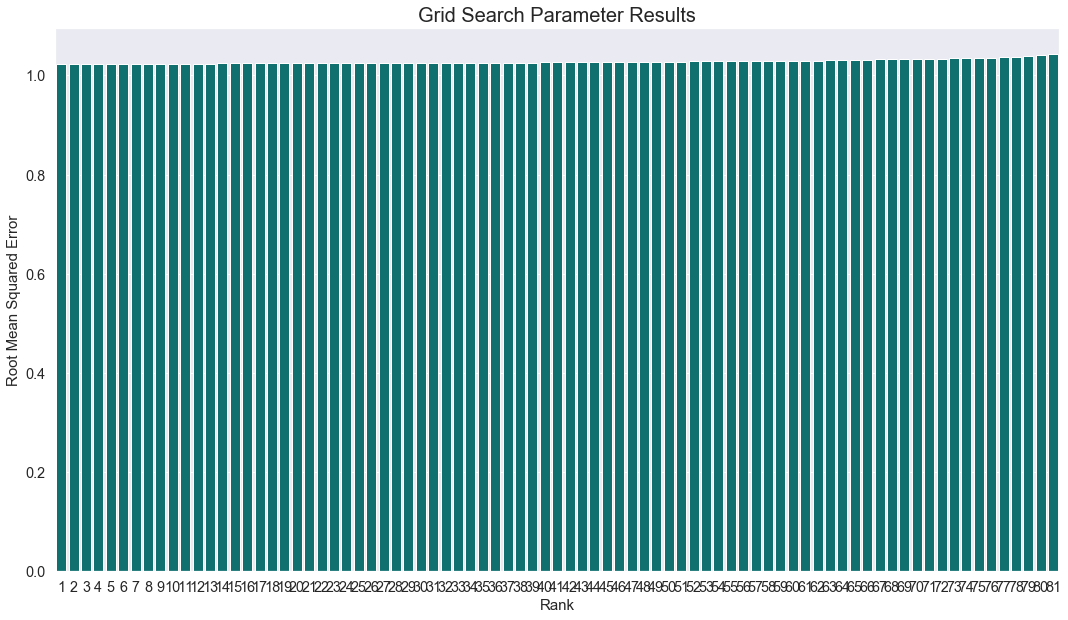

{'n_factors': 25, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.1} 1.0230381120422083


In [98]:
data = create_interactions_matrix(user_ratings_df.sample(100000, random_state=24))

# Create parameter grid for SVD
param_grid = {'n_factors': [25, 50,100],
                  'n_epochs': [20,30,50],       
                  'lr_all': [0.002,0.005,0.01],
                  'reg_all':[0.02,0.1, 0.4]}

print('-------------------SVD----------------------')
# Perform gridsearch and plot results
gridsearch(SVD, param_grid, data, cv=3)

Baseline Only can be run using alternating least squares (ALS) or stochastic gradient descent (SGD) to reduce error. 

There are additional hyperparameters that can be selected based on the preferred method of Baseline however. Their default respective default parameters will be used here however.

-------------------Baseline Only ALS----------------------
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,params,mean_test_rmse,rank_test_rmse
0,{'bsl_options': {'method': 'als'}},1.023444,1


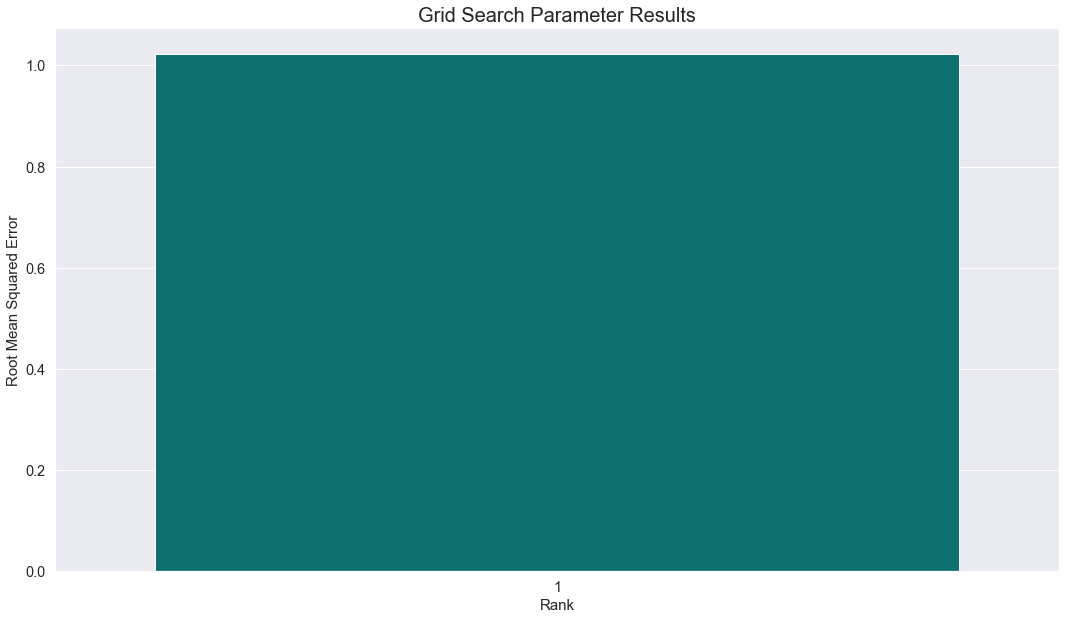

{'bsl_options': {'method': 'als'}} 1.0234441819535598
 
-------------------Baseline Only SGD----------------------
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...


,params,mean_test_rmse,rank_test_rmse
0,{'bsl_options': {'method': 'sgd'}},1.023603,1


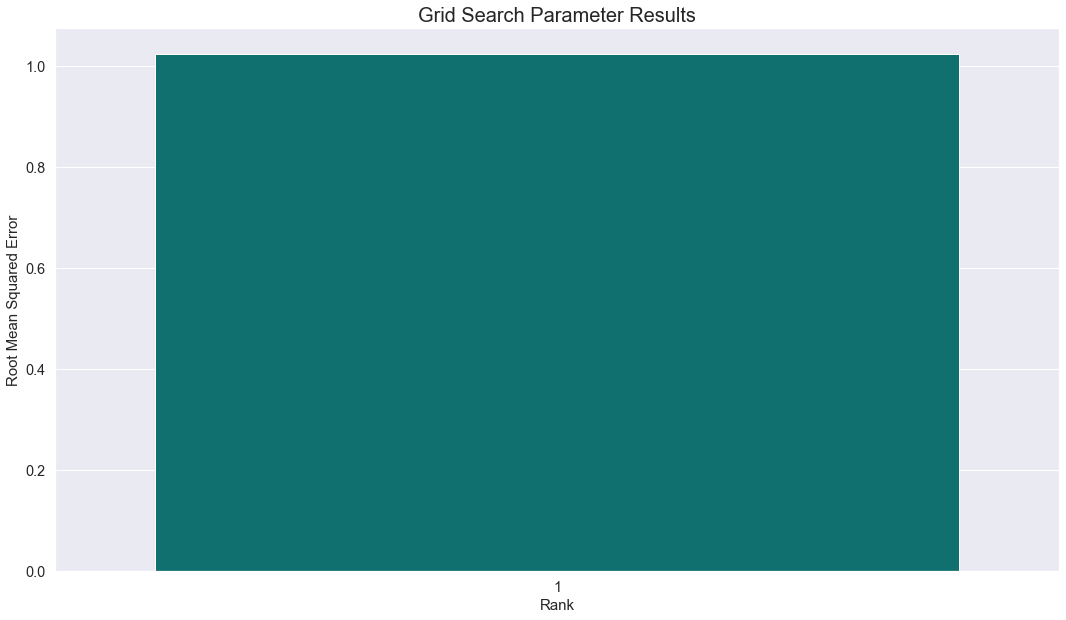

{'bsl_options': {'method': 'sgd'}} 1.0236029769111747


In [99]:
print('-------------------Baseline Only ALS----------------------')
# Perform gridsearch and plot results
param_grid = {'bsl_options': {'method': ['als'],
                             }   
             }
gridsearch(BaselineOnly, param_grid, data, cv=3)

print(' ')
print('-------------------Baseline Only SGD----------------------')
# Perform gridsearch and plot results
param_grid = {'bsl_options': {'method': ['sgd'],
                             }
             }
gridsearch(BaselineOnly, param_grid, data, cv=3)

Cross validation hyperparameter tunining indicated that Baseline with stochastic gradient descent baseline performed better than both alternating least squares baseline and SVD. For the baseline algorithm, SGD will be used as the method moving forward.

The optimal hyperparamter values from the SVD grid search indicate {'n_factors': 25, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.1}. To create more precise settings, more granular values will be tested above and below these optimal values. Worth noting however, is that the mean RMSE seems to level off on the far left of the output. 

,params,mean_test_rmse,rank_test_rmse
44,"{'n_factors': 25, 'n_epochs': 30, 'lr_all': 0....",1.022231,1
8,"{'n_factors': 20, 'n_epochs': 25, 'lr_all': 0....",1.022258,2
7,"{'n_factors': 20, 'n_epochs': 25, 'lr_all': 0....",1.022268,3
6,"{'n_factors': 20, 'n_epochs': 25, 'lr_all': 0....",1.022290,4
70,"{'n_factors': 30, 'n_epochs': 30, 'lr_all': 0....",1.022290,5
...,...,...,...
27,"{'n_factors': 25, 'n_epochs': 25, 'lr_all': 0....",1.026859,77
2,"{'n_factors': 20, 'n_epochs': 25, 'lr_all': 0....",1.026902,78
54,"{'n_factors': 30, 'n_epochs': 25, 'lr_all': 0....",1.026921,79
56,"{'n_factors': 30, 'n_epochs': 25, 'lr_all': 0....",1.027028,80


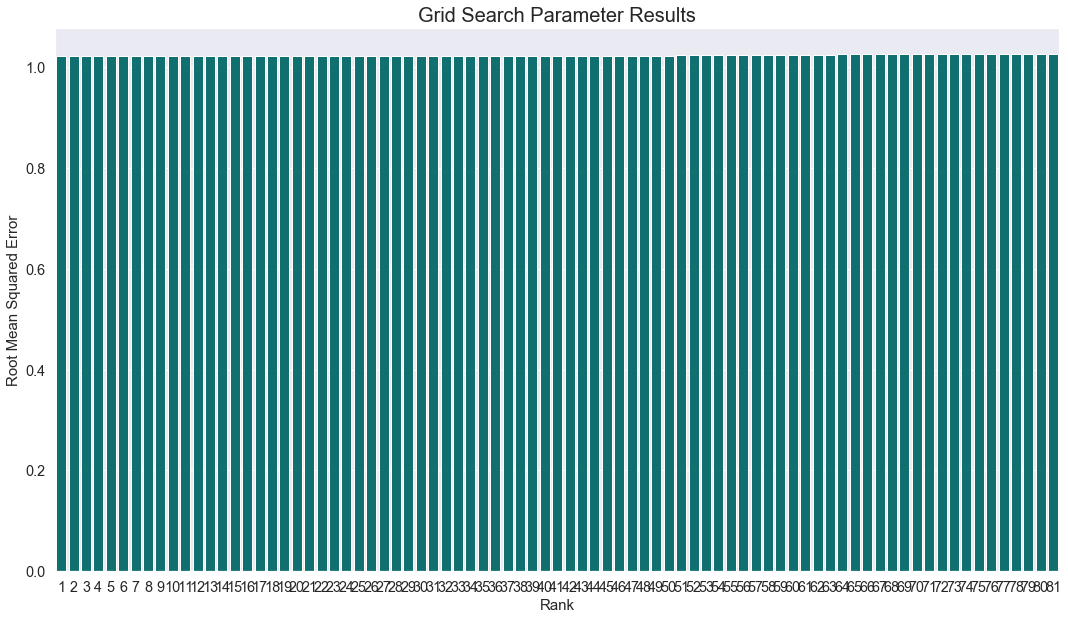

{'n_factors': 25, 'n_epochs': 30, 'lr_all': 0.003, 'reg_all': 0.2} 1.0222310747249292


In [100]:
param_grid = {'n_factors': [20, 25, 30],
                  'n_epochs': [25, 30, 35],       
                  'lr_all': [0.001,0.002,0.003],
                  'reg_all':[0.08,0.1, 0.2]}

# Perform gridsearch and plot results
gridsearch(SVD, param_grid, data, cv=3)

As suspected, the tuning has plateaued with its performance. The below hyperparameter values are selected as optimal for final prediction using Surprise SVD.

In [38]:
SVD_params = [['n_factors', 25],
              ['n_epochs',30],
              ['lr_all',0.003 ],
              ['reg_all',0.2]
             ]
print('SVD optimal parameters')
print(tabulate.tabulate(SVD_params))


Baseline_params = [['method', 'sgd']]
print('Baseline Only optimal parameters')
print(tabulate.tabulate(Baseline_params))

# Instantiate SVD model with parameters from above
SVD_algo = SVD(n_factors=SVD_params[0][1], 
             n_epochs=SVD_params[1][1],
             lr_all=SVD_params[2][1], 
             reg_all=SVD_params[3][1])

Baseline_algo = BaselineOnly(bsl_options={'method': 'als'})

SVD optimal parameters
---------  ------
n_factors  20
n_epochs   30
lr_all      0.003
reg_all     0.2
---------  ------
Baseline Only optimal parameters
------  ---
method  sgd
------  ---


Below, the model will be trained on a training set and tested on a test set. To allow the training portion to pick up on emerging user trends and build a baseline of 
ratings, the data here will be sorted by submission date. Specifically, the training set will consist of the first 70% of the ratings and the test set will feature the remaining 30%. 
The median of rating submissions by users in this dataset is 1. Hypothetically, if the dataset was less skewed in this regard and the typical user had more than a single rating, splitting the train and test set by user and submission date would be recommended. For example, for a user with 6 rating submissions, using the first 5 submissions to train and predict on the 6th recipe would be an appropriate approach.

In [43]:
# Recreate repeater and first_time datasets ensuring sort by rating submission date.
repeater_data_sorted, first_timer_data_sorted =repeat_or_first_time_users(interactions_df.sort_values('date',ascending=False))

# Recreate ratings dataframe
user_ratings_df_sorted = create_user_ratings_df(repeater_data_sorted)

# Recreate interactions matrix carrying sort
interactions_matrix = create_interactions_matrix(user_ratings_df_sorted)

# Segment beginning 70% for training and remaining 30% for testing
trainset, testset = train_test_split(interactions_matrix, test_size=0.3, train_size=0.7, shuffle=False)

%timeit -t SVD_algo.fit(trainset)
SVD_predictions = SVD_algo.test(testset)
print('SVD RMSE:')
accuracy.rmse(SVD_predictions)

%timeit -t Baseline_algo.fit(trainset)
Baseline_predictions = Baseline_algo.test(testset)
print('Baseline RMSE:')
accuracy.rmse(Baseline_predictions)

34.7 s ± 798 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SVD RMSE:
RMSE: 1.0307
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
2.73 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Baseline RMSE:
RMSE: 1.0306


1.0306054712366086

Training on 70% of the dataset shows that SVD and Baseline (using sgd) perform rather similarly with very close RMSE. Below, their performance will be compared more closely.

In [44]:
##### Create prediction result dataframe 
SVD_pred_results = pd.DataFrame(SVD_predictions, columns = ['new_user_id',
                                                    'new_recipe_id',
                                                    'actual_rating',
                                                    'pred_rating',
                                                    'details'])
Baseline_pred_results = pd.DataFrame(Baseline_predictions, columns = ['new_user_id',
                                                    'new_recipe_id',
                                                    'actual_rating',
                                                    'pred_rating',
                                                    'details'])
pred_results_combined = pd.merge(SVD_pred_results,
                                 Baseline_pred_results[['new_user_id','new_recipe_id','pred_rating']],
                                 how='inner',
                                 on=['new_user_id', 'new_recipe_id'],
                                 suffixes=('_svd','_base'))

display(pred_results_combined.head(3))
display(pred_results_combined.describe())

,new_user_id,new_recipe_id,actual_rating,pred_rating_svd,details,pred_rating_base
0,u488441,r386918,5.0,4.780628,{'was_impossible': False},4.826572
1,u488441,r387288,5.0,4.780628,{'was_impossible': False},4.826572
2,u488441,r387873,5.0,5.000000,{'was_impossible': False},5.000000


,actual_rating,pred_rating_svd,pred_rating_base
count,289834.000000,289834.000000,289834.000000
mean,4.534991,4.540851,4.536807
std,1.033598,0.141208,0.138046
min,0.100000,3.290663,3.315932
25%,4.000000,4.495975,4.491933
50%,5.000000,4.550818,4.546296
75%,5.000000,4.623165,4.616767
max,5.000000,5.000000,5.000000


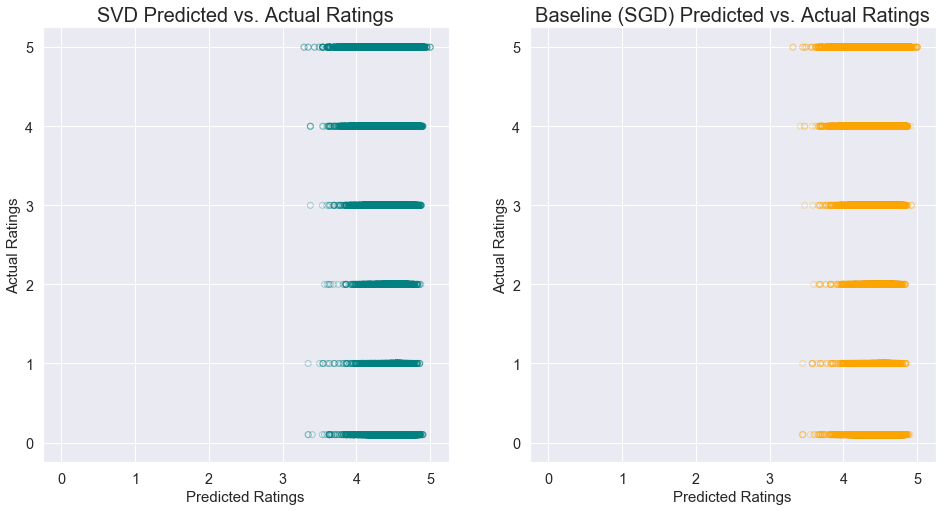

In [45]:
# Plot actuals vs. residuals
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(pred_results_combined['pred_rating_svd'], pred_results_combined['actual_rating'], marker='o', facecolor='none', edgecolors='teal',alpha=.3)
plt.xlim(-.25, 5.25)
plt.ylim(-.25, 5.25)
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.title('SVD Predicted vs. Actual Ratings')

plt.subplot(1,2,2)
plt.scatter(pred_results_combined['pred_rating_base'], pred_results_combined['actual_rating'], marker='o', facecolor='none', edgecolors='orange',alpha=.3)
plt.xlim(-.25, 5.25)
plt.ylim(-.25, 5.25)
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.title('Baseline (SGD) Predicted vs. Actual Ratings')
plt.show()

Similar to the original raw data, predictions seems to be very skewed towards 3.5 to 5. 

Below residuals are plotted against the actual ratings submitted for the recipe.

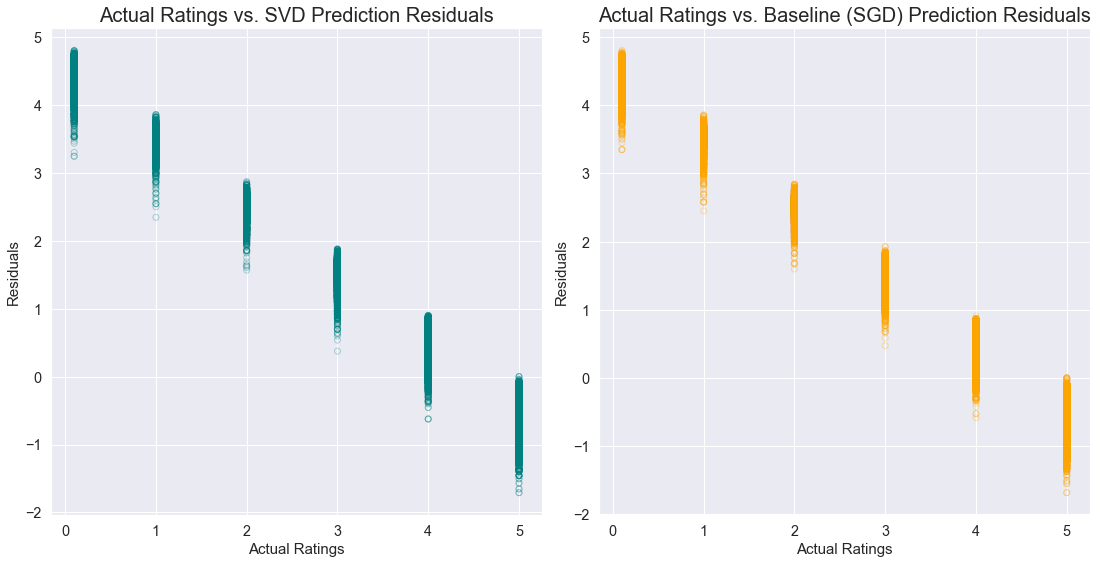

In [46]:
pred_results_combined['resid_svd'] = pred_results_combined['pred_rating_svd'] - pred_results_combined['actual_rating']
pred_results_combined['resid_base'] = pred_results_combined['pred_rating_base'] - pred_results_combined['actual_rating']

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(pred_results_combined['actual_rating'],pred_results_combined['resid_svd'], marker='o', facecolor='none', edgecolors='teal', alpha=.3)
plt.xlabel('Actual Ratings')
plt.ylabel('Residuals')
plt.title('Actual Ratings vs. SVD Prediction Residuals')

plt.subplot(1,2,2)
plt.scatter(pred_results_combined['actual_rating'],pred_results_combined['resid_base'], marker='o', facecolor='none', edgecolors='orange',alpha=.3)
plt.xlabel('Actual Ratings')
plt.ylabel('Residuals')
plt.title('Actual Ratings vs. Baseline (SGD) Prediction Residuals')
plt.tight_layout()
plt.show()

As suspected, recipes with low ratings have higher prediction residuals. On the contrary, minimal residuals are shown near recipes with actual ratings around 4.

Below, rmse is evaluated on each actual rating level to see if the algorithms perform differently on certain rating submissions.

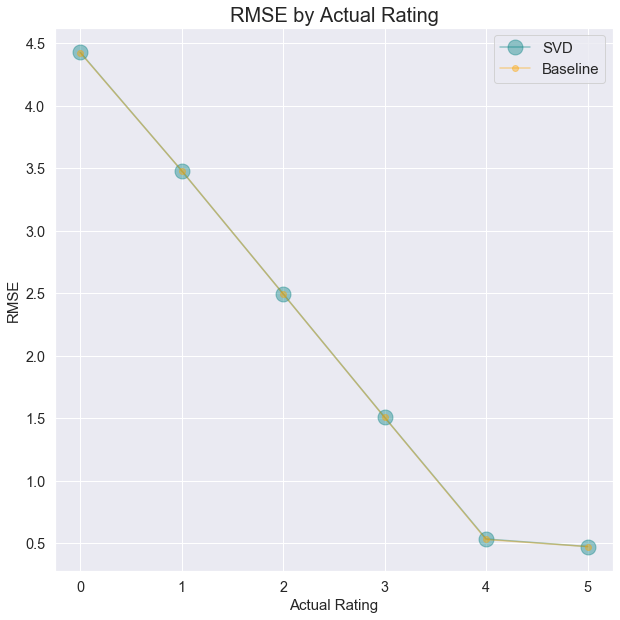

In [23]:
# Calculate RMSE by actual rating for each model
rmse_by_rating = pred_results_combined.groupby(['actual_rating'])['resid_svd','resid_base'].agg(lambda x:np.sqrt(np.mean(list(x**2)))).reset_index()
plt.plot(rmse_by_rating.index, rmse_by_rating.resid_svd, marker='o', label='SVD', c='teal', alpha=0.4, markerfacecolor=None, markersize=15)
plt.plot(rmse_by_rating.index, rmse_by_rating.resid_base, marker='o', label='Baseline', c='orange', alpha=0.4)
plt.xlabel('Actual Rating')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE by Actual Rating')
plt.show()

Both algorithms show similar behavior in error among the possible rating values submitted by users.

As suspected, recipes with low ratings have higher prediction residuals. On the contrary, minimal residuals are shown near recipes with actual ratings around 4.

# Feature Engineering: Recommend Top N Recipes from Collaborative Filtering Predictions

Next, a function will be created to provide the top N recipes that a user has not rated in the dataset. Such a procedure could be used to drive recipe recommendations using collaborative filtering. The function will create a matrix that contains all user + recipe combinations that do not already exist. 
As a result, it faces severe memory contrants. To combat this but still leverage its functionality, a sample of the ratings will be fed into it. Since the recommended recipes resulting from this procedure will be later merged with similar recipes made by any given user, the sample used here will feature the most commonly rated recipes by the most active users. The functions below will be used to create this filtering dynamically.

In [71]:
def common_recipes(vol_threshold=10,user_ratings_df=user_ratings_df):
    """
    Returns list of new_recipe_id values that have been rated at least as many times specified in vol_threshold
    
    Optional Parameters:
    vol_threshold (integer): number of ratings threshold
    user_ratings_df: dataframe corresponding to ratings of repeat users, i.e. no cold start users
    """
        
    rating_count_df = user_ratings_df.groupby(['new_recipe_id'], as_index=False).size().to_frame('rating_vol')
    rating_count_df.reset_index(inplace=True)
    recipe_list = list(rating_count_df['new_recipe_id'].loc[rating_count_df.rating_vol>=vol_threshold].unique())
    return recipe_list

In [72]:
def common_users(vol_threshold=10,user_ratings_df=user_ratings_df):
    """
    Returns list of new_user_id values that have submitted reviews as many times as specified in vol_threshold
    
    Optional Parameters:
    vol_threshold (integer): number of rating submissions threshold
    user_ratings_df: dataframe corresponding to ratings of repeat users, i.e. no cold start users
    """
        
    rating_count_df = user_ratings_df.groupby(['new_user_id'], as_index=False).size().to_frame('rating_vol')
    rating_count_df.reset_index(inplace=True)
    user_list = list(rating_count_df['new_user_id'].loc[rating_count_df.rating_vol>=vol_threshold].unique())
    return user_list

In [74]:
def get_top_n(predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Parameters
    predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
    n(int): The number of recommendation to output for each user. Default
            is 5.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# Train Baseline Only algorithm using random sample of highly active users due to local memory constraints
data = create_interactions_matrix(user_ratings_df.loc[(user_ratings_df.new_user_id.isin(common_users(vol_threshold=150)))].sample(10000, random_state=13))
trainset = data.build_full_trainset()
Baseline_algo = BaselineOnly(bsl_options={'method': 'als'})
Baseline_algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
anti_testset = trainset.build_anti_testset()
predictions = Baseline_algo.test(anti_testset)

# Provide predictions from Baseline test from original train and test
# Results in a dictionary with user as key and value as list of tuples (recipe, predicted rating)
top_n_collab = get_top_n(predictions, n=10)

Estimating biases using als...


# Content Based Filtering

Below recipes will be explored and their similarity evaluated for content-based filtering. While the recipes can be simlar in instructions, ingredients, techniques, and tags, the below will feature filtering by tags to provide a more comprehensive filtering with a single element of information.
The result of content-based filtering will be merged with the recommendations from collaborative filtering to further strengthen some of the top 10 recommendations from collaborative filtering. 

In [75]:
# Parse list-like tags columns into appropriate Python data types
recipes_df['tags'] = recipes_df['tags'].apply(literal_eval)
unique_tags = pd.Series(Counter(chain.from_iterable(x for x in recipes_df.tags)))
recipe_cnt = len(recipes_df)
unique_tags = unique_tags.to_frame().reset_index()
unique_tags.columns=['tag','rec_volume']

# Add column for percentage of recipes that carry each tag
unique_tags['pctg_of_rec'] = unique_tags['rec_volume']/recipe_cnt
print("Common recipe tags:")
unique_tags.sort_values('rec_volume',ascending=False, inplace=True)
display(unique_tags.head(10))

print('')
print("Recipe tag distribution:")
display(unique_tags.describe())

Common recipe tags:


,tag,rec_volume,pctg_of_rec
5,preparation,230546,0.995290
1,time-to-make,225326,0.972755
2,course,218148,0.941767
3,main-ingredient,170446,0.735832
16,dietary,165091,0.712714
11,easy,126062,0.544222
6,occasion,114145,0.492775
4,cuisine,91165,0.393568
65,low-in-something,85776,0.370304
22,main-dish,71786,0.309907



Recipe tag distribution:


,rec_volume,pctg_of_rec
count,552.000000,552.000000
mean,7503.057971,0.032391
std,23358.831344,0.100842
min,1.000000,0.000004
25%,96.250000,0.000416
50%,757.500000,0.003270
75%,4240.500000,0.018307
max,230546.000000,0.995290


There are only 552 different tags which is manageable. Furthermore, on average a tag is used for ~7.5k recipes and the median of tag usage is for less than 800, indicating there are a lot of tags used very little. Additionally, viewing some of the most used tags indicates perhaps noisy ones, such as 'course', 'cuisine', 'time-to-make'. Such tags could likely be refined further perhaps from initial scraping. To combat the noise of obviously unimportant phrases/words, some can be captured as stop words for the majority of vectorizers.

In addition, TF-IDF may offer additional support for its downgrading of repeatedly used words. However, the term-frequency portion of TF-IDF is not entirely applicable as it seeks to evaluate words used repeatedly in a single document (i.e. recipe in this scenario). Since tags are not listed mutiple times in a recipe it's not entirely applicable. Alongside of TF-IDF Count Vectorizer is a good baseline to use as well. Here, the Count Vectorizer will simply capture binary flags for tags used in a recipe.

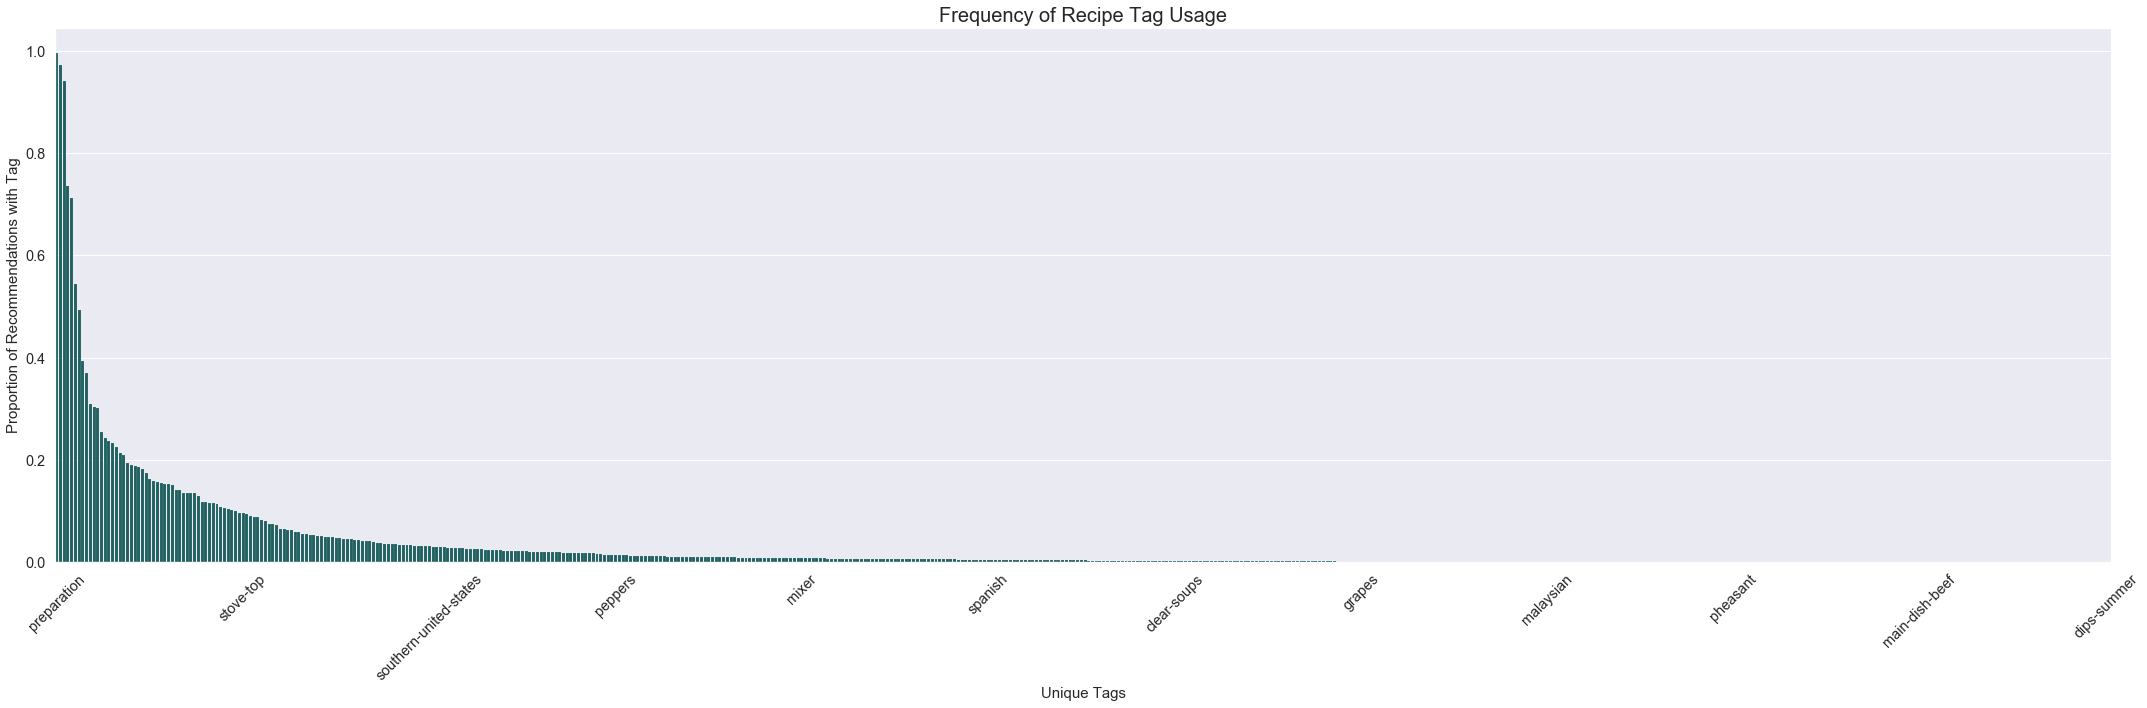

In [76]:
plt.figure(figsize=(30,10))
ax = sns.barplot(unique_tags.tag,
                unique_tags.pctg_of_rec,
                color='teal',
                edgecolor = "white",
                linewidth = 0.1,
                saturation=0.5)
plt.xlabel('Unique Tags')
n=50
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
plt.xticks(rotation=45)
plt.ylabel("Proportion of Recommendations with Tag")
plt.title('Frequency of Recipe Tag Usage')
plt.tight_layout()
plt.show()

In [13]:
display(unique_tags.sort_values('pctg_of_rec',ascending=False).head(20))

,tag,rec_volume,pctg_of_rec
5,preparation,230546,0.995290
1,time-to-make,225326,0.972755
2,course,218148,0.941767
3,main-ingredient,170446,0.735832
16,dietary,165091,0.712714
11,easy,126062,0.544222
6,occasion,114145,0.492775
4,cuisine,91165,0.393568
65,low-in-something,85776,0.370304
22,main-dish,71786,0.309907


In [77]:
# Capture obvious stop words from recipes
stop_words = ['preparation', 'time-to-make', 'course','main-ingredient','occasion','cuisine','low-in-something','equipment','number-of-servings']
new_stop_words = []
for phrase in stop_words:
    new_stop_words.append(phrase.replace(" ", "").replace("-", ""))
print(new_stop_words)

['preparation', 'timetomake', 'course', 'mainingredient', 'occasion', 'cuisine', 'lowinsomething', 'equipment', 'numberofservings']


Since there are over 200k recipes, which means creating a dot product of the similarities of these recipes wil create an array of length 200k squared. Thus, again for local resources, the recipe similarity filtering here wil be done using only a subset. 

In [78]:
# Create new_recipe_id field for matching to most commonly reviewed recipes
recipes_df['new_recipe_id'] = recipes_df['id'].apply(lambda x: 'r'+str(x))

# Create reduced recipe dataframe
reduced_recipes_df = recipes_df.loc[recipes_df.new_recipe_id.isin(common_recipes(vol_threshold=30))]
reduced_recipes_df.reset_index(inplace=True, drop=True)

# Create a function to remove spaces and hyphens from tags list
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "").replace("-", "")) for i in x]
    else:

        if isinstance(x, str):
            return [str.lower(i.replace(" ", "").replace("-", "")) for i in x]
        else:
            return ''
        
reduced_recipes_df['tags'] = reduced_recipes_df['tags'].apply(clean_data)

# Create string of all tags
def create_soup(x):
    return ' '.join(x['tags'])

reduced_recipes_df['tags'] = reduced_recipes_df.apply(create_soup, axis=1)

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [79]:
# Count Vectorization method to create binary hot key encoders for tags

# Instantiate CountVectorizer with custom stop words
count_vect = CountVectorizer(stop_words=new_stop_words, lowercase=False, binary=True)
CVec_count_matrix = count_vect.fit_transform(reduced_recipes_df['tags'])

# Calculate cosine similarity matrix by using dot product of vectorizers
CVec_cosine_sim = cosine_similarity(CVec_count_matrix, CVec_count_matrix) 

# Reset index and construct reverse mapping for lookup of similar recipes
reduced_recipes_df = reduced_recipes_df.reset_index(drop=True)
CVec_indices = pd.Series(reduced_recipes_df.index, index=reduced_recipes_df['name'])

In [80]:
# TF-IDF Vectorization method to capture IDF specifically for repeating tags across recipes

# Instantiate TF-IDF Vectorizer with custom stop words
tfidf_vect = TfidfVectorizer(stop_words=new_stop_words, lowercase=False, binary=True)
TFIDF_count_matrix = tfidf_vect.fit_transform(reduced_recipes_df['tags'])

# Calculate cosine similarity matrix by using dot product of vectorizers
TFIDF_cosine_sim = linear_kernel(TFIDF_count_matrix, TFIDF_count_matrix) 

# Reset index and construct reverse mapping for lookup of similar recipes
reduced_recipes_df = reduced_recipes_df.reset_index(drop=True)
TFIDF_indices = pd.Series(reduced_recipes_df.index, index=reduced_recipes_df['name'])

In [81]:
# Create a function to produce top 1 recipe based on Count Vectorization similarity to recipe provided

def get_similar_recipe_CVec(recipe_name, indices=CVec_indices, cosine_sim=CVec_cosine_sim):
    """
    Returns top 1 similar recipes from provided recipe
    
    Parameters:
    recipe_name (string): recipe name
        
    """
        
    # Ensure provided recipe has been evaluted for its similarities
    if indices.index.contains(recipe_name):
        # Get the index of the recipe that matches the name. Use min in event of duplicate recipes
        idx = indices[recipe_name].min()

        # Get the pairwsie similarity scores of all recipes with that recipe
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the recipes based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the most similar recipe
        sim_scores = sim_scores[1:2]

        # Get the recipe indices
        recipe_indices = [i[0] for i in sim_scores]

        # Return the most similar recipe
        return reduced_recipes_df['name'].iloc[recipe_indices]
    else:
        return ' '

In [82]:
# Create a function to produce top 1 recipe based on TF-IDF Vectorization similarity to recipe provided

def get_similar_recipe_TFIDF(recipe_name, indices=TFIDF_indices, cosine_sim=TFIDF_cosine_sim):
    """
    Returns top 1 similar recipes from provided recipe
    
    Parameters:
    recipe_name (string): recipe name
        
    """
        
    # Ensure provided recipe has been evaluted for its similarities
    if indices.index.contains(recipe_name):
        # Get the index of the recipe that matches the name. Use min in event of duplicate recipes
        idx = indices[recipe_name].min()

        # Get the pairwsie similarity scores of all recipes with that recipe
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the recipes based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the most similar recipe
        sim_scores = sim_scores[1:2]

        # Get the recipe indices
        recipe_indices = [i[0] for i in sim_scores]

        # Return the most similar recipe
        return reduced_recipes_df['name'].iloc[recipe_indices]
    else:
        return ' '

In [83]:
# Create a funtion to view results of random content filtering

def test_get_similar_recipe(random_seed, reduced_recipes_df=reduced_recipes_df):
    """
    Returns top 1 similar recipes from provided recipe using both count vectorization and tf-idf vectorization
    
    Parameters:
    random_seed (integer): random seed selection for repeatable results
        
    """
    random_state=random_seed
    name_in = list(reduced_recipes_df['name'].sample(1, random_state=random_state))[0]
    tag_in =  list(recipes_df['tags'].loc[recipes_df.name == name_in])[0]
    CVec_output_name = list(get_similar_recipe_CVec(name_in))[0]
    CVec_output_tags = list(recipes_df['tags'].loc[recipes_df.name == CVec_output_name])[0]
    TFIDF_output_name = list(get_similar_recipe_TFIDF(name_in))[0]
    TFIDF_output_tags = list(recipes_df['tags'].loc[recipes_df.name == TFIDF_output_name])[0]
    CVec_shared_tags = list(set(tag_in).intersection(CVec_output_tags))
    TFIDF_shared_tags = list(set(tag_in).intersection(TFIDF_output_tags))
    print("RECIPE INPUT")
    input_rec = [['Recipe:', 'Associated Tags'],
                          [name_in, tag_in]]
    print(tabulate.tabulate(input_rec))
    print(' ')
    print("COUNT VECTORIZATION OUTPUT")
    output_rec1 = [['Recipe:', 'Shared Tags'],
                          [CVec_output_name, CVec_shared_tags]]
    print(tabulate.tabulate(output_rec1))
    print(' ')
    print("TF-IDF VECTORIZATION OUTPUT")
    output_rec2 = [['Recipe:', 'Shared Tags'],
                          [TFIDF_output_name, TFIDF_shared_tags]]
    print(tabulate.tabulate(output_rec2))
    
    
test_get_similar_recipe(13)
print(' ')
test_get_similar_recipe(15)

RECIPE INPUT
----------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Recipe:                             Associated Tags
boeuf bourguignon a la julia child  ['time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'main-dish', 'soups-stews', 'beef', 'vegetables', 'french', 'european', 'dinner-party', 'stews', 'mushrooms', 'meat', 'onions']
----------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 
COUNT VECTORIZATION OUTPUT
---------------------------------------  -------------------------------------------------------------------------------------------------------------------------

Viewing the above 2 examples of content filtering outputs highlights two qualitative items worth noting. Firstly, the recipes noted as similar for a given recipe are logical. A French stew returns more French stews and an Asian noodle dish returns 2 more Asian noodle dishes. What is also worth noting is that in some scenarios, the Count Vector and TF-IDF Vectorizer results are different whereas in others they are the same.

# Feature Engineering: Merge Collaborative Filtering with Content Filtering

The top 10 recommendations from collaborative filtering will be further curated by the content filtering above. Specifically, any of the 10 recommendations from collaborative filtering that are similar to a user's previous recipes will be noted as such. Additional feature engineering could include providing the recipe that each recommendation was similar to as well as that user's rating of that similar recipe. Furthermore, the similarity filtering be reduced to the top 5 similar recipes of the user's previously rated recipes.

In [84]:
def merge_filtering(top_n_collab):
    """
    Returns dataframe with a row per user with 100+ ratings submitted, up to 10 recommendations, and any recipes the user has rated that are similar to the recommendations
    
    Parameters:
    top_n_collab (dictionary): dictionary with user as key and value as list of tuples (recipe, predicted rating) name
        
    """
    df = pd.DataFrame(columns=['new_user_id',
                               'recipe_rec_ids', 
                               'recipe_rec_names',
                               'similar_recipe'])
    for uid, user_ratings in top_n_collab.items():
        recipe_IDs = [iid for (iid, _) in user_ratings]
        recipe_names = []
        similar_recipes = []
        for idx, rec_id in enumerate(recipe_IDs):
            recipe_names.extend(recipes_df['name'].loc[recipes_df['new_recipe_id']==rec_id])
            similar_recipes.extend(get_similar_recipe_CVec(recipe_names[idx]))
        df = df.append({'new_user_id':uid, 
                        'recipe_rec_ids':recipe_IDs, 
                        'recipe_rec_names':recipe_names, 
                        'similar_recipe':similar_recipes}, ignore_index=True)
    return df

recommendation_df = merge_filtering(top_n_collab)    

In [85]:
recommendation_df.head()

,new_user_id,recipe_rec_ids,recipe_rec_names,similar_recipe
0,u38182,"[r69173, r24088, r251220, r94520, r46877, r209...",[kittencal s italian melt in your mouth meatba...,"[meatloaf haters meatloaf, orange julius smoot..."
1,u85873,"[r69173, r24088, r251220, r94520, r46877, r209...",[kittencal s italian melt in your mouth meatba...,"[meatloaf haters meatloaf, orange julius smoot..."
2,u186802,"[r69173, r24088, r251220, r94520, r46877, r209...",[kittencal s italian melt in your mouth meatba...,"[meatloaf haters meatloaf, orange julius smoot..."
3,u218535,"[r69173, r24088, r251220, r94520, r46877, r209...",[kittencal s italian melt in your mouth meatba...,"[meatloaf haters meatloaf, orange julius smoot..."
4,u213139,"[r69173, r24088, r251220, r94520, r46877, r209...",[kittencal s italian melt in your mouth meatba...,"[meatloaf haters meatloaf, orange julius smoot..."


In [86]:
def pick_user_get_recs(recommendation_df=recommendation_df):
    idx= random.randint(0,len(recommendation_df))
    user = recommendation_df.iloc[idx,0]
    recipe_recs = recommendation_df.iloc[idx,2]
    recipe_recs = [sub.replace(' s ',"'s ") for sub in recipe_recs]
    similar_recipes = recommendation_df.iloc[idx,3]
    similar_recipes = [sub.replace(' s ',"'s ") for sub in similar_recipes]
    print('For user {}, we recommend you try:'.format(user))
    for idx, rec in enumerate(recipe_recs):
        print("- {} recipe.".format(rec))
        if similar_recipes[idx]!=' ':
            print("     it's similar to the {} recipe you rated previously".format(similar_recipes[idx]))
        else:
            None

pick_user_get_recs()

For user u95743, we recommend you try:
- kittencal's italian melt in your mouth meatballs recipe.
     it's similar to the meatloaf haters meatloaf recipe you rated previously
- strawberry julius recipe.
     it's similar to the orange julius smoothies recipe you rated previously
- kittencal's fluffiest scrambled eggs recipe.
     it's similar to the the best fluffiest buttermilk pancakes on the planet recipe you rated previously
- simple tomato and avocado salad recipe.
     it's similar to the pan roasted broccoli recipe you rated previously
- uncle bill's whipped shortbread cookies recipe.
     it's similar to the devil bites recipe you rated previously
- weight watchers french toast recipe.
- roasted brussels sprouts recipe.
     it's similar to the spice roasted butternut squash with smoked sweet paprika recipe you rated previously
- buttermilk chocolate bread recipe.
     it's similar to the amish friendship bread and starter recipe you rated previously
- my favorite chili recipe

# Feature Engineering: Most Popular Recipes

As mentioned prior, cold star users should receive the most popular recipes as initial recommendations. Due to the skewed nature of ratings, a mean or median may be the most applicable to determine popularity. The below function provides an option for either. Furthermore, a volume threshold should serve as a cutoff to ensure only well vetted recipes are submitted.

In [87]:
def most_popular_recs(recipes_df=recipes_df,interactions_df=interactions_df, vol_threshold=50, use_mean=True, top_N=10):
    """
    Returns top N recipes based on popularity (defined by above the vol_threshold and mean or median
    
    Optional Parameters:
    recipes_df (dataframe): original recipe dataframe
    interaction_df (dataframe): original ratings dataframe
    vol_threshold (integer): threshold of rating submissions for a recipe to be considered as popular
    use_mean (boolean): decision variable to distinguish using mean or median rating for popularity
    top_N (integer): number of recipes to return
        
    """
    if use_mean==True:
        agg_rating = interactions_df.groupby(['recipe_id'])['rating'].agg(['mean','size']).reset_index()
    else:
        agg_rating = interactions_df.groupby(['recipe_id'])['rating'].agg(['median','size']).reset_index()
    agg_rating.drop((agg_rating.loc[agg_rating['size']<vol_threshold]).index, inplace=True)
    agg_rating.columns=('id','agg','vol')
    new_df = pd.merge(agg_rating,
                      recipes_df[['id','name']],
                      on='id',
                      how='left')
    return new_df.sort_values('agg', ascending=False).head(top_N)

In [88]:
most_popular_recs()

,id,agg,vol,name
939,55309,5.000000,52,caprese salad tomatoes italian marinated toma...
2143,486261,4.990783,217,mexican stack up rsc
726,42038,4.964912,57,syrup for blueberry pancakes
331,21033,4.963636,55,toffee dip with apples
2044,248495,4.962264,53,make your own boursin cheese paula deen
374,23495,4.960000,50,mean s lamb you can eat with a spoon
1046,63621,4.959459,74,mango salsa 1
1002,59776,4.952381,63,scott hibb s amazing whiskey grilled baby back...
2144,486267,4.941176,51,summer vegetable grill packets rsc
660,37455,4.940299,67,boboli pizza crust clone


# Feature Engineering: Ingredient List Creation

Based on the recipe recommenations or user selection, a function should be available to create a consolidated list of ingredients, removing duplicates, and appending items as necessary from added recipes

In [137]:
# Parse list-like ingredients columns into appropriate Python data types
recipes_df['ingredients'] = recipes_df['ingredients'].apply(literal_eval)
def get_ingredients(new_recipe_IDs, starting_list, recipes_df=recipes_df):
    """
    Returns listing of unique ingredients for list and recipes provided
    
    Parameters:
    new_recipe_IDs (list): new recipe IDs of selected recipes 
    recipes_df (dataframe): original recipe dataframe; literal_eval must already have been applied to ingredients column
    starting_list (list): existing list of ingredients; use empty list if list does not exist
        
    """
    
    ingred_list = starting_list
    for rec_ID in new_recipe_IDs:
        ingred_list.extend(list(recipes_df['ingredients'].loc[recipes_df.new_recipe_id == rec_ID])[0])
    ingred_list = sorted(ingred_list)
    ingred_list = set(ingred_list)
    return ingred_list

In [176]:
recipes_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,new_recipe_id
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7,r137739
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6,r31490
2,all in the kitchen chili,112140,130,196586,2005-02-25,"[time-to-make, course, preparation, main-dish,...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13,r112140
3,alouette potatoes,59389,45,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11,r59389
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"[weeknight, time-to-make, course, main-ingredi...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8,r44061


In [179]:
def get_random_ingredients(recipes_df=recipes_df):
    rec_list = recipes_df.iloc[random.randint(0,len(recipes_df)), recipes_df.columns.get_loc('ingredients')]
    print("Existing grocery list:")
    print(sorted(rec_list))
    print(' ')
    print('User selects to add these recommendations:')
    item_1_idx = random.randint(0,len(recipes_df))
    item_1_name = recipes_df.iloc[item_1_idx, recipes_df.columns.get_loc('name')]
    item_1_ID = recipes_df.iloc[item_1_idx, recipes_df.columns.get_loc('new_recipe_id')]
    item_1_ingredients = recipes_df.iloc[item_1_idx, recipes_df.columns.get_loc('ingredients')]
    item_2_idx = random.randint(0,len(recipes_df))
    item_2_name = recipes_df.iloc[item_2_idx, recipes_df.columns.get_loc('name')]
    item_2_ID = recipes_df.iloc[item_2_idx, recipes_df.columns.get_loc('new_recipe_id')]
    item_2_ingredients = recipes_df.iloc[item_2_idx, recipes_df.columns.get_loc('ingredients')]
    output_recs = [[item_1_name, item_1_ingredients],
                   [item_2_name, item_2_ingredients]]
    print(tabulate.tabulate(output_recs))
    combined_list = get_ingredients(new_recipe_IDs = [item_1_ID,item_2_ID], starting_list=rec_list)
    print(' ')
    print("New grocery list includes:")
    print(sorted(combined_list))
get_random_ingredients()

Existing grocery list:
['brown bread', 'brown rice', 'butter', 'buttermilk', 'cheese', 'chicken stock', 'chipotle chile in adobo', 'cornstarch', 'garlic', 'ground chicken', 'ricotta cheese', 'sage leaves', 'salt', 'stewed tomatoes', 'zucchini']
 
User selects to add these recommendations:
-----------------------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
yellow russian summer    ['ice', 'peach ice cream', 'milk', 'peach schnapps', 'vodka']
broccoli cheddar latkes  ['broccoli floret', 'russet potato', 'onion', 'panko breadcrumbs', 'eggs', 'black pepper', 'salt', 'cayenne pepper', 'flour', 'shredded cheddar cheese', 'canola oil', 'vegetable oil']
-----------------------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Evaluating Effect of Imbalanced Dataset

As noted before, 80% of the original raw data features ratings of 4 or 5. To evaluate if this is the cause of the predictions only featuring figures between 3.5 and 5, the models will be trained on a balanced dataset. Specifically, lower ratings will be oversampled with replacement to enusre that there are equal rating submissions of 1, 2, 3, 4, and 5.

In [12]:
# Obtain max number of ratings of 0-5 possibilities
max_size = interactions_df['rating'].value_counts().max()

# Sample 
lst = [interactions_df]
for class_index, group in interactions_df.groupby('rating'):
    lst.append(group.sample(max_size-len(group), replace=True, random_state=13))
interactions_df_resampled = pd.concat(lst)

display(interactions_df_resampled.head(5))

,user_id,recipe_id,date,rating,review,new_user_id,new_recipe_id
0,38094,40893,2003-02-17,4.0,Great with a salad. Cooked on top of stove for...,u38094,r40893
1,1293707,40893,2011-12-21,5.0,"So simple, so delicious! Great for chilly fall...",u1293707,r40893
2,8937,44394,2002-12-01,4.0,This worked very well and is EASY. I used not...,u8937,r44394
3,126440,85009,2010-02-27,5.0,I made the Mexican topping and took it to bunk...,u126440,r85009
4,57222,85009,2011-10-01,5.0,"Made the cheddar bacon topping, adding a sprin...",u57222,r85009


In [13]:
SVD_params = [['n_factors', 25],
              ['n_epochs',30],
              ['lr_all',0.003 ],
              ['reg_all',0.1]
             ]
print('SVD optimal parameters')
print(tabulate.tabulate(SVD_params))


Baseline_params = [['method', 'sgd']]
print('Baseline Only optimal parameters')
print(tabulate.tabulate(Baseline_params))

# Instantiate SVD model with parameters from above
SVD_algo = SVD(n_factors=SVD_params[0][1], 
             n_epochs=SVD_params[1][1],
             lr_all=SVD_params[2][1], 
             reg_all=SVD_params[3][1])

Baseline_algo = BaselineOnly(bsl_options={'method': 'als'})

SVD optimal parameters
---------  ------
n_factors  25
n_epochs   30
lr_all      0.003
reg_all     0.1
---------  ------
Baseline Only optimal parameters
------  ---
method  sgd
------  ---


In [14]:
# Instantiate SVD model with parameters from above
SVD_algo = SVD(n_factors=SVD_params[0][1], 
             n_epochs=SVD_params[1][1],
             lr_all=SVD_params[2][1], 
             reg_all=SVD_params[3][1])

Baseline_algo = BaselineOnly(bsl_options={'method': 'als'})

# Recreate repeater and first_time datasets ensuring sort by rating submission date.
repeater_data_sorted_res, first_timer_data_sorted_res =repeat_or_first_time_users(interactions_df_resampled.sort_values('date',ascending=False))

# Substitue manual transformation used in create_user_ratings_df to avoid grouping the bootstrapped samples
user_ratings_df_sorted_res = repeater_data_sorted_res[['new_user_id','new_recipe_id','rating']].rename({'rating':'estimator'}, axis=1)
user_ratings_df_sorted_res['estimator'] = round(user_ratings_df_sorted_res['estimator'].astype('float64'),1)

# Recreate interactions matrix carrying sort
interactions_matrix_res = create_interactions_matrix(user_ratings_df_sorted_res)

# Segment beginning 70% for training and remaining 30% for testing
trainset_res, testset_res = train_test_split(interactions_matrix_res, test_size=0.3, train_size=0.7, shuffle=False)

%timeit -t SVD_algo.fit(trainset_res)
SVD_predictions_res = SVD_algo.test(testset_res)
print('SVD RMSE:')
accuracy.rmse(SVD_predictions_res)

%timeit -t Baseline_algo.fit(trainset_res)
Baseline_predictions_res = Baseline_algo.test(testset_res)
print('Baseline RMSE:')
accuracy.rmse(Baseline_predictions_res)

3min 35s ± 46.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
SVD RMSE:
RMSE: 1.4842
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
13.5 s ± 259 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Baseline RMSE:
RMSE: 1.5181


1.518135305706125

Comparing prediction performance between original and re-sampled data reveals that overall the re-sampled set performed worse. Specifically, the SVD rmse increased from 1.0307 to 1.4832 and the Baseline Only (sgd) increased from 1.0306 to 1.5181. However, the areas of this performance change will be further explored below.

In [15]:
# Create prediction result dataframe 
SVD_pred_results_res = pd.DataFrame(SVD_predictions_res, columns = ['new_user_id',
                                                    'new_recipe_id',
                                                    'actual_rating',
                                                    'pred_rating',
                                                    'details'])
Baseline_pred_results_res = pd.DataFrame(Baseline_predictions_res, columns = ['new_user_id',
                                                    'new_recipe_id',
                                                    'actual_rating',
                                                    'pred_rating',
                                                    'details'])
pred_results_combined_res = pd.merge(SVD_pred_results_res,
                                 Baseline_pred_results_res[['new_user_id','new_recipe_id','pred_rating']],
                                 how='inner',
                                 on=['new_user_id', 'new_recipe_id'],
                                 suffixes=('_svd','_base'))

display(pred_results_combined_res.head(3))
display(pred_results_combined_res.describe())

,new_user_id,new_recipe_id,actual_rating,pred_rating_svd,details,pred_rating_base
0,u596424,r17509,2.0,2.227326,{'was_impossible': False},1.372103
1,u596424,r17509,2.0,2.227326,{'was_impossible': False},1.372103
2,u596424,r17509,2.0,2.227326,{'was_impossible': False},1.372103


,actual_rating,pred_rating_svd,pred_rating_base
count,3.723878e+07,3.723878e+07,3.723878e+07
mean,1.866434e+00,2.841723e+00,2.664157e+00
std,9.329582e-01,7.293696e-01,7.815286e-01
min,1.000000e-01,1.000000e-01,1.000000e-01
25%,1.000000e+00,2.274180e+00,2.274180e+00
50%,2.000000e+00,2.731074e+00,2.550311e+00
75%,2.000000e+00,3.377012e+00,3.202690e+00
max,5.000000e+00,5.000000e+00,5.000000e+00


Evaluating the statistical spread of predictions using a more balanced dataset does in fact shows a difference. Specifically, the minimum predicted ratings do drop from ~3 to that of the lowest true possible rating.

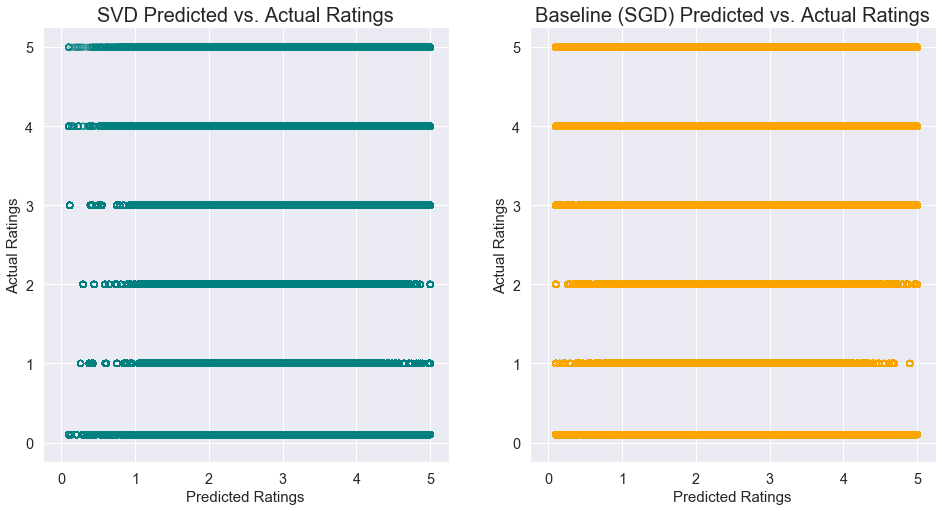

In [16]:
# Plot actuals vs. residuals
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(pred_results_combined_res['pred_rating_svd'], pred_results_combined_res['actual_rating'], marker='o', facecolor='none', edgecolors='teal',alpha=.3)
plt.xlim(-.25, 5.25)
plt.ylim(-.25, 5.25)
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.title('SVD Predicted vs. Actual Ratings')

plt.subplot(1,2,2)
plt.scatter(pred_results_combined_res['pred_rating_base'], pred_results_combined_res['actual_rating'], marker='o', facecolor='none', edgecolors='orange',alpha=.3)
plt.xlim(-.25, 5.25)
plt.ylim(-.25, 5.25)
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.title('Baseline (SGD) Predicted vs. Actual Ratings')
plt.show()

As expected, predictions using a re-sampled set have a much higher variance across all real ratings. Similar to the prior predictions, this variance tends to be slightly stronger at each of the ends of ratings, i.e. ~0 and 5.

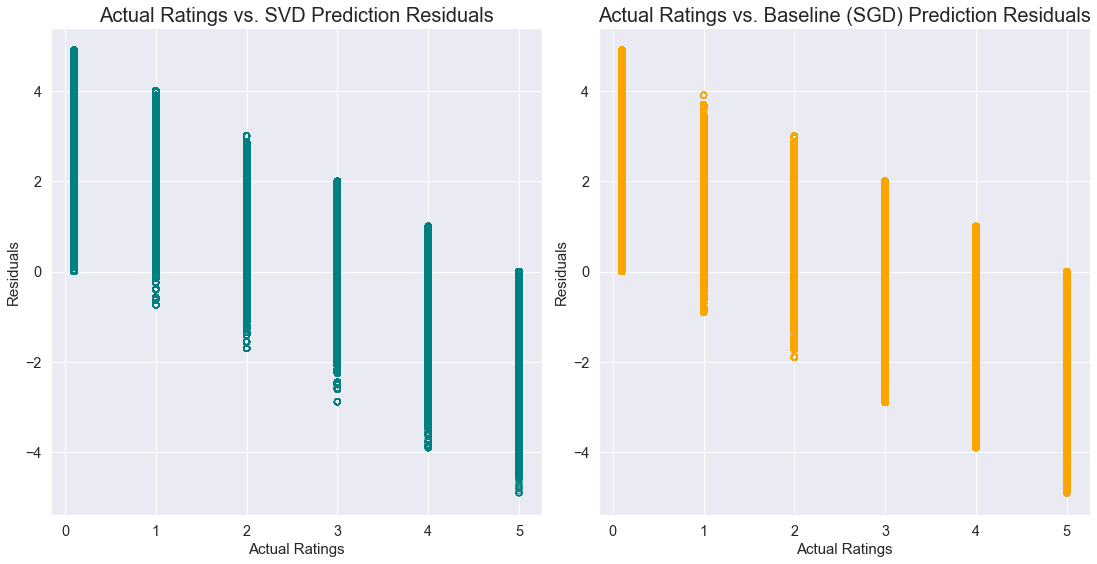

In [17]:
pred_results_combined_res['resid_svd'] = pred_results_combined_res['pred_rating_svd'] - pred_results_combined_res['actual_rating']
pred_results_combined_res['resid_base'] = pred_results_combined_res['pred_rating_base'] - pred_results_combined_res['actual_rating']

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(pred_results_combined_res['actual_rating'],pred_results_combined_res['resid_svd'], marker='o', facecolor='none', edgecolors='teal', alpha=.3)
plt.xlabel('Actual Ratings')
plt.ylabel('Residuals')
plt.title('Actual Ratings vs. SVD Prediction Residuals')

plt.subplot(1,2,2)
plt.scatter(pred_results_combined_res['actual_rating'],pred_results_combined_res['resid_base'], marker='o', facecolor='none', edgecolors='orange',alpha=.3)
plt.xlabel('Actual Ratings')
plt.ylabel('Residuals')
plt.title('Actual Ratings vs. Baseline (SGD) Prediction Residuals')
plt.tight_layout()
plt.show()

The lowest residuals were seen around the highest ratings in the original predictions. Here however, the residuals closest to 0 are seen around the 2-3 range. Similarly, many of the ratings predicted to be 5 are seen with more extreme negative residuals, indicating a high rating for some recipes was not appropriate. 

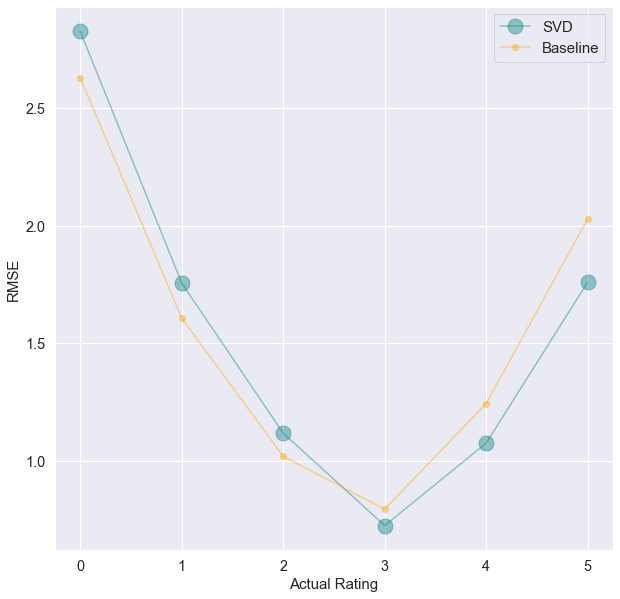

In [18]:
# Calculate RMSE by actual rating for each model
rmse_by_rating = pred_results_combined_res.groupby(['actual_rating'])['resid_svd','resid_base'].agg(lambda x:np.sqrt(np.mean(list(x**2)))).reset_index()
plt.plot(rmse_by_rating.index, rmse_by_rating.resid_svd, marker='o', label='SVD', c='teal', alpha=0.4, markerfacecolor=None, markersize=15)
plt.plot(rmse_by_rating.index, rmse_by_rating.resid_base, marker='o', label='Baseline', c='orange', alpha=0.4)
plt.xlabel('Actual Rating')
plt.ylabel('RMSE')
plt.legend()
plt.show()

With resampled data, while still close the algorithms behave slightly differently. The Baseline algorithm performs better for ratings 0 through 2 while the SVD performs better for ratings between 3 and 5.